<a href="https://colab.research.google.com/github/mateopolancecofficial/NLP/blob/main/WineReviews/SequenceModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -l -s https://github.com/mateopolancecofficial/NLP.git

Cloning into 'NLP'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 5), reused 22 (delta 5), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("/content/NLP/WineReviews/data/winemag-data-130k-v2.csv", index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
df = df[['description', 'points']]
df.head()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


In [11]:
df.description.isnull().sum()

0

In [12]:
# shuffle the DataFrame rows
df = df.sample(frac = 1)
df.head()

,description,points
28583,"Honey-sweet and simple, with crisp, jammy flav...",83
52429,"Round and smooth, this delivers sensations of ...",90
63310,"This is a solid showing, with aromas of toaste...",87
116073,"Gritty aromas of berry fruits, wild herbs and ...",90
127872,"With a fine spicy character, the wine from thi...",87


In [29]:
df.description = df.description.str.replace('\d+', '')

In [34]:
# split on the training and validation sets
from sklearn.model_selection import train_test_split

text_train, text_val, y_train, y_val = train_test_split(df.description, df.points,
                                                  test_size=0.2,train_size=0.8)


In [46]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

In [47]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [48]:
# tokenize 
x_train, x_val, tokenizer_word_index = sequence_vectorize(text_train.tolist(), 
                                                          text_val.tolist())

In [49]:
x_train

array([[   0,    0,    0, ...,  135,   23,   20],
       [   0,    0,    0, ...,   23,   45,   64],
       [   0,    0,    0, ...,  374,    4, 2005],
       ...,
       [   0,    0,    0, ...,    3,  499, 1293],
       [   0,    0,    0, ...,   49,   23,   45],
       [   0,    0,    0, ..., 1624,   23,  165]], dtype=int32)

In [57]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    return model

In [51]:
num_features = min(len(tokenizer_word_index) + 1, TOP_K)
data = {'x_train': x_train, 'x_val': x_val, 'y_train': y_train, 'y_val': y_val}

In [58]:
def train_sequence_model(data,
                         learning_rate=1e-3,
                         epochs=1000,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    x_train = data['x_train']
    train_labels = data['y_train']
    x_val = data['x_val']
    val_labels = data['y_val']  

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                        filters=filters,
                        kernel_size=kernel_size,
                        embedding_dim=embedding_dim,
                        dropout_rate=dropout_rate,
                        pool_size=pool_size,
                        input_shape=x_train.shape[1:],
                        num_features=num_features)

    # Compile model with learning parameters.
    loss = 'mean_squared_error'
    metric = 'mean_squared_error'

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
                        x_train,
                        train_labels,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(x_val, val_labels),
                        verbose=2,  # Logs once per epoch.
                        batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation mean_squared_error: {mse}, loss: {loss}'.format(
            mse=history['val_mean_squared_error'][-1], 
            loss=history['val_loss'][-1]))

    # Save model.
    model.save('wine_reviews_seq.h5')
    return history

In [59]:
history = train_sequence_model(data)

Streaming output truncated to the last 5000 lines.
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1479 in d

In [65]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Points]')
  plt.legend()
  plt.grid(True)

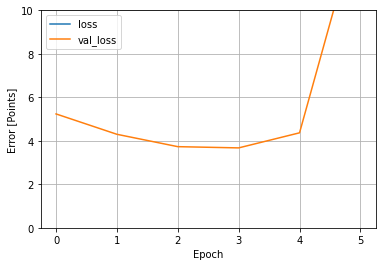

In [66]:
plot_loss(history)